#Mini Project 2 - Sentiment Analysis - Satu Laukkanen

##Imports

In [209]:
import csv
import pandas as pd
import numpy as np
from numpy import array
from numpy import asarray
from numpy import zeros
import matplotlib.pyplot as plt
import re

import seaborn as sns

#stop words
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [210]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dropout, Dense, Embedding
from tensorflow.keras.layers import Flatten, Conv1D, LSTM
from tensorflow.keras.layers import GlobalMaxPooling1D
from tensorflow.keras.layers import Dropout

Please update the file path here before running.

In [211]:
import os
from google.colab import drive
drive.mount('/content/drive')

#please update your own file path here
folder_path = '/content/drive/My Drive/Machine Learning/Mini Project 2'
files = os.listdir(folder_path)
print(files)

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
['IMDB_Dataset.csv', 'Attempt1.ipynb', 'Attempt2.ipynb', 'Attempt3.ipynb', 'Attempt5.ipynb', 'Attempt4.ipynb', 'Attempt7.ipynb']


##Data Frame Creation and Visual Data Analysis

In [212]:
reviews = pd.read_csv(folder_path + "/IMDB_Dataset.csv")
reviews.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


The data frame consists of 50000 rows and two columns.

In [213]:
reviews.shape

(50000, 2)

There are no null values.

In [214]:
reviews.isnull().sum()

,0
review,0
sentiment,0


The distribution of positive and negative reviews is even.

<Axes: xlabel='sentiment', ylabel='count'>

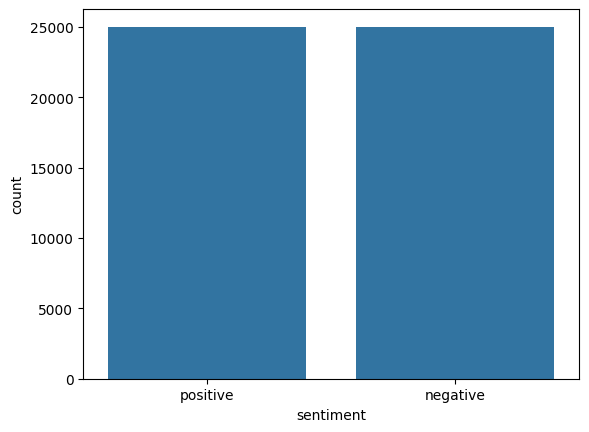

In [215]:
sns.countplot(x='sentiment', data=reviews)

Upon inspection reviews have HTML tags, which need to be cleaned before continuing with the analysis.

In [216]:
reviews["review"][0]

"One of the other reviewers has mentioned that after watching just 1 Oz episode you'll be hooked. They are right, as this is exactly what happened with me.<br /><br />The first thing that struck me about Oz was its brutality and unflinching scenes of violence, which set in right from the word GO. Trust me, this is not a show for the faint hearted or timid. This show pulls no punches with regards to drugs, sex or violence. Its is hardcore, in the classic use of the word.<br /><br />It is called OZ as that is the nickname given to the Oswald Maximum Security State Penitentary. It focuses mainly on Emerald City, an experimental section of the prison where all the cells have glass fronts and face inwards, so privacy is not high on the agenda. Em City is home to many..Aryans, Muslims, gangstas, Latinos, Christians, Italians, Irish and more....so scuffles, death stares, dodgy dealings and shady agreements are never far away.<br /><br />I would say the main appeal of the show is due to the fa

##Data Cleaning

In [217]:
TAG_RE = re.compile(r'<[^>]+>')
def remove_tags(text):
    return TAG_RE.sub('', text)

def remove_stop_words(text):
    return ' '.join([word for word in text.split() if word.lower() not in stop_words])

def preprocess_text(sen):
    #remove tags
    sentence = remove_tags(sen)
    #remove stop words
    sentence = remove_stop_words(sentence)
    #remove punctuation and numbers
    sentence = re.sub('[^a-zA-Z]', ' ', sentence)
    #remove single charachters
    sentence = re.sub(r"\s+[a-zA-Z]\s+", ' ', sentence)
    #remove multiple spaces
    sentence = re.sub(r'\s+', ' ', sentence)
    return sentence

#cleaned reviews are stored
X = []
sentences = list(reviews['review'])
for sen in sentences:
    processed = preprocess_text(sen)
    X.append(processed)

In [218]:
X[0]

'One reviewers mentioned watching Oz episode hooked right exactly happened me The first thing struck Oz brutality unflinching scenes violence set right word GO Trust me show faint hearted timid show pulls punches regards drugs sex violence hardcore classic use word It called OZ nickname given Oswald Maximum Security State Penitentary focuses mainly Emerald City experimental section prison cells glass fronts face inwards privacy high agenda Em City home many Aryans Muslims gangstas Latinos Christians Italians Irish more so scuffles death stares dodgy dealings shady agreements never far away would say main appeal show due fact goes shows dare Forget pretty pictures painted mainstream audiences forget charm forget romance OZ mess around first episode ever saw struck nasty surreal say ready it watched more developed taste Oz got accustomed high levels graphic violence violence injustice crooked guards who ll sold nickel inmates who ll kill order get away it well mannered middle class inmat

In [219]:
X[5]

'Probably all time favorite movie story selflessness sacrifice dedication noble cause preachy boring never gets old despite seen times last years Paul Lukas performance brings tears eyes Bette Davis one truly sympathetic roles delight kids are grandma says like dressed up midgets children makes fun watch mother slow awakening what happening world roof believable startling dozen thumbs up movie '

##Creation of train and test sets

In [220]:
#used as randomization seed in this project
seed = 42

###Splitting and conversion of sentiment to integers

Labels are converted from "positive" and "negative" to 1 and 0.

Positive = 1, negative = 0.

In [221]:
y = reviews['sentiment']

#map positive reviews as 1 and negative as 0, an array of 0's and 1's
y = np.array(list(map(lambda x: 1 if x=="positive" else 0, y)))

print(y[0])
print(y[3])

1
0


In [222]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=seed)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.50, random_state=seed)

#sizes of sets
print(f"Training: {len(X_train)}, Validation: {len(X_val)}, Testing: {len(X_test)}")

print(X_train[0])
print(y_train[0])

Training: 35000, Validation: 7500, Testing: 7500
much love trains stomach movie premise one could steal locomotive drive Arkansas Chicago without hitting another train along way right Impossible Plot lines hit board Imagine two disgruntled NASA employees stealing crawler totes shuttles fro driving New York get idea Having said that nice try Wilford Brimely Quaker Oats best Levon Helm turns good performance dimwitted well meaning sidekick Bob Balaban suitably wormy Corporate Guy little guy takes Goliath story gets another airing 
0


###Tokenizer

At this point, we use Tokenizer to map words to integers.

Tokenization is used for the CNN and RNN models, and it is the first part of preparing the data for the embedding layer.

In [223]:
tokenizer = Tokenizer(num_words=6000)

#fit on training data
tokenizer.fit_on_texts(X_train)

#Convert all sequnces, without fitting validation and test data
X_train_token = tokenizer.texts_to_sequences(X_train)
X_test_token = tokenizer.texts_to_sequences(X_test)
X_val_token = tokenizer.texts_to_sequences(X_val)

In [224]:
print(X_train[0])

much love trains stomach movie premise one could steal locomotive drive Arkansas Chicago without hitting another train along way right Impossible Plot lines hit board Imagine two disgruntled NASA employees stealing crawler totes shuttles fro driving New York get idea Having said that nice try Wilford Brimely Quaker Oats best Levon Helm turns good performance dimwitted well meaning sidekick Bob Balaban suitably wormy Corporate Guy little guy takes Goliath story gets another airing 


In [225]:
print(X_train_token[0])

[15, 39, 2874, 1, 764, 3, 24, 2019, 1250, 3393, 109, 3308, 70, 965, 244, 25, 106, 1093, 36, 317, 502, 1688, 723, 34, 2844, 1682, 78, 770, 17, 229, 4410, 207, 31, 234, 254, 41, 429, 5, 142, 14, 1078, 3796, 1848, 4887, 114, 44, 114, 214, 11, 117, 70]


In this block, we can inspect what words were kept by the tokenizer in X[0].

In [226]:
word_index = tokenizer.word_index

index_word = {index: word for word, index in word_index.items()}

original_words = [index_word[idx] for idx in X_train_token[0] if idx in index_word]
print(" ".join(original_words))


much love stomach movie premise one could steal drive chicago without hitting another train along way right impossible plot lines hit board imagine two stealing driving new york get idea having said that nice try best turns good performance well meaning sidekick bob corporate guy little guy takes story gets another


Index 0 is reserved, so we add one to ensure that vocab_size accounts for all words. Padding is also added at this point. All the lists get the length 100.

In [227]:
vocab_size = len(tokenizer.word_index) + 1

maxlen = 100

X_train_nn = pad_sequences(X_train_token, padding='post', maxlen=maxlen)
X_val_nn = pad_sequences(X_val_token, padding='post', maxlen=maxlen)
X_test_nn = pad_sequences(X_test_token, padding='post', maxlen=maxlen)

###Embedding

As the training, validation and testing sets are split, and the texts are tokenized, it is time to create the feature matrix. Embeddings are also used in the CNN and RNN models.

In [228]:
import kagglehub

path = kagglehub.dataset_download("danielwillgeorge/glove6b100dtxt")
print("Path to dataset files:", path)
print("Downloaded files:", os.listdir(path))

Path to dataset files: /root/.cache/kagglehub/datasets/danielwillgeorge/glove6b100dtxt/versions/1
Downloaded files: ['glove.6B.100d.txt']


Glove embeddings are loaded into a dictionary.

In [229]:
embeddings_dictionary = dict()

glove_path = os.path.join(path, "glove.6B.100d.txt")

with open(glove_path, "r", encoding="utf8") as glove_file:
  for line in glove_file:
      records = line.split()
      word = records[0]
      vector_dimensions = asarray(records[1:], dtype='float32')
      embeddings_dictionary [word] = vector_dimensions
  glove_file.close()

print("Amount of words in embeddings dictionary:", len(embeddings_dictionary))

Amount of words in embeddings dictionary: 400000


Create an embedding matrix that maps the created vocabulary words to correspoding glove word vectors.

In [230]:
embedding_matrix = zeros((vocab_size, 100))
for word, index in tokenizer.word_index.items():
    embedding_vector = embeddings_dictionary.get(word)
    if embedding_vector is not None:
        embedding_matrix[index] = embedding_vector

###TF-IDF

In order to train XGBoost, we need to convert the data sets to a suitable TF-IDF vecor representation. For this, the original, un-tokenized sets are used.

In [231]:
print(X_train[0]) #check that X_train is still in the original format

much love trains stomach movie premise one could steal locomotive drive Arkansas Chicago without hitting another train along way right Impossible Plot lines hit board Imagine two disgruntled NASA employees stealing crawler totes shuttles fro driving New York get idea Having said that nice try Wilford Brimely Quaker Oats best Levon Helm turns good performance dimwitted well meaning sidekick Bob Balaban suitably wormy Corporate Guy little guy takes Goliath story gets another airing 


In [232]:
from sklearn.feature_extraction.text import TfidfVectorizer

vectorizer = TfidfVectorizer(max_features=5000)
X_train_tfidf = vectorizer.fit_transform(X_train)
X_val_tfidf = vectorizer.transform(X_val)
X_test_tfidf = vectorizer.transform(X_test)

In [233]:
print(X_train_tfidf[0])

  (0, 2920)	0.07430843933114838
  (0, 2652)	0.08958726717475723
  (0, 4214)	0.19983383039271244
  (0, 2912)	0.048805096618754304
  (0, 3363)	0.15247517292576598
  (0, 3103)	0.05110558539161894
  (0, 975)	0.07980070098730259
  (0, 4189)	0.1869390581877706
  (0, 1332)	0.17129721933107456
  (0, 743)	0.21077427669190807
  (0, 4923)	0.1044879168919654
  (0, 2109)	0.2050297769509692
  (0, 195)	0.1934625109087895
  (0, 4565)	0.17188523297523933
  (0, 138)	0.12067248775467102
  (0, 4836)	0.07986388025766075
  (0, 3703)	0.10474914120074372
  (0, 2229)	0.16385845866146098
  (0, 3302)	0.08543511215013397
  (0, 2595)	0.12814166141277433
  (0, 2104)	0.14160832644556634
  (0, 472)	0.180682619585051
  (0, 2218)	0.14965121759277633
  (0, 4631)	0.0862273128205238
  (0, 4190)	0.20030208485179618
  (0, 1337)	0.18042480581106163
  (0, 2997)	0.10162872814378088
  (0, 4989)	0.15780226798922828
  (0, 1875)	0.07583071880521376
  (0, 2194)	0.12031646267793063
  (0, 2037)	0.21567083266808937
  (0, 3791)	0.11691

##Models

###XGBoost

In [234]:
import xgboost as xgb

xgb_m = xgb.XGBClassifier(
    n_estimators=200,
    max_depth=6,
    learning_rate=0.1,
    colsample_bytree=0.8,
    subsample=0.8,
    random_state=seed
)

xgb_m.fit(X_train_tfidf, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.8, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=6, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=200, n_jobs=None,
              num_parallel_tree=None, random_state=42, ...)

In [235]:
y_pred = xgb_m.predict(X_val_tfidf)

accuracy = accuracy_score(y_val, y_pred)
print("XGBoost Accuracy:", accuracy)

XGBoost Accuracy: 0.8562666666666666


In [236]:
y_pred = xgb_m.predict(X_test_tfidf)

accuracy = accuracy_score(y_test, y_pred)
print("XGBoost Accuracy:", accuracy)

XGBoost Accuracy: 0.858


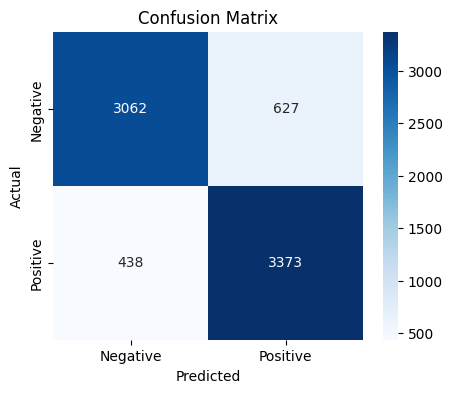

In [237]:
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(5,4))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

In [238]:
report_dict = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
df_report

,precision,recall,f1-score,support
0,0.874857,0.830035,0.851857,3689.000
1,0.843250,0.885070,0.863654,3811.000
accuracy,0.858000,0.858000,0.858000,0.858
macro avg,0.859054,0.857552,0.857755,7500.000
weighted avg,0.858796,0.858000,0.857851,7500.000


###CNN

In [239]:
model = Sequential()

#Embedding layer
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)
model.add(embedding_layer)

#Convolutional layer
model.add(Conv1D(64, 5, activation='relu'))
#Global MaxPooling
model.add(GlobalMaxPooling1D())
#Early drop out
model.add(Dropout(0.5))
#Fully connected output layer
model.add(Dense(1, activation='sigmoid'))

model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

In [240]:
model.build(input_shape=(None, maxlen))
print(model.summary())

Model: "sequential_10"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_10 (Embedding)             │ (None, 100, 100)            │       8,752,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv1d_6 (Conv1D)                    │ (None, 96, 64)              │          32,064 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_max_pooling1d_6               │ (None, 64)                  │               0 │
│ (GlobalMaxPooling1D)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_6 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_10 (Dense)                     │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,784,429 (33.51 MB)

 Trainable params: 32,129 (125.50 KB)

 Non-trainable params: 8,752,300 (33.39 MB)

None


In [241]:
#train on train set, validate on validation set
history = model.fit(X_train_nn, y_train, batch_size=32, epochs=6, verbose=1, validation_data=(X_val_nn, y_val))

#use test set
score = model.evaluate(X_test_nn, y_test, verbose=1)

Epoch 1/6
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 17ms/step - acc: 0.6815 - loss: 0.6029 - val_acc: 0.8248 - val_loss: 0.4002
Epoch 2/6
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 17s 16ms/step - acc: 0.8110 - loss: 0.4129 - val_acc: 0.8333 - val_loss: 0.3772
Epoch 3/6
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 17s 15ms/step - acc: 0.8317 - loss: 0.3795 - val_acc: 0.8421 - val_loss: 0.3686
Epoch 4/6
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 18s 16ms/step - acc: 0.8408 - loss: 0.3606 - val_acc: 0.8280 - val_loss: 0.3860
Epoch 5/6
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 20s 16ms/step - acc: 0.8466 - loss: 0.3489 - val_acc: 0.8411 - val_loss: 0.3618
Epoch 6/6
1094/1094 ━━━━━━━━━━━━━━━━━━━━ 22s 17ms/step - acc: 0.8529 - loss: 0.3382 - val_acc: 0.8449 - val_loss: 0.3609
235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 6ms/step - acc: 0.8410 - loss: 0.3533


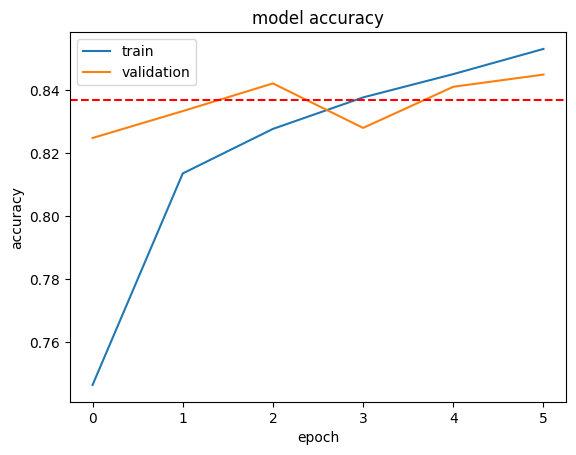

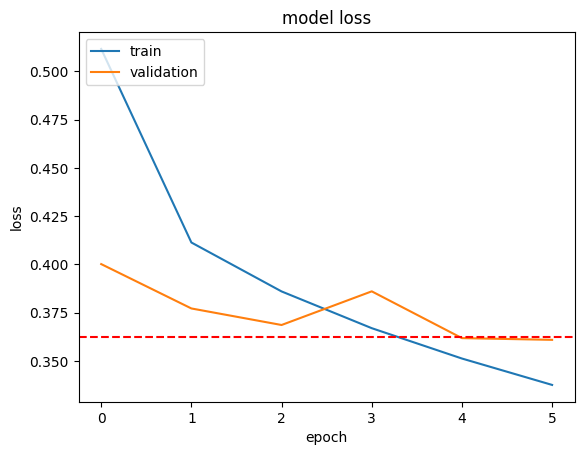

In [242]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.axhline(y=score[1], color='r', linestyle='--', label='Test Accuracy')

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axhline(y=score[0], color='r', linestyle='--', label='Test Loss')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc = 'upper left')
plt.show()

235/235 ━━━━━━━━━━━━━━━━━━━━ 1s 5ms/step


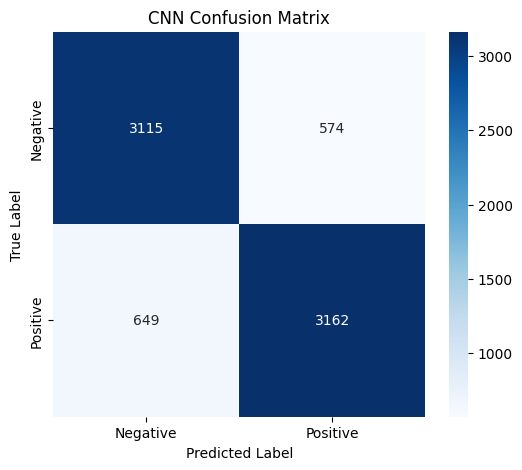

In [243]:
#predicted probabilities
y_pred_probs = model.predict(X_test_nn)

y_pred = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('CNN Confusion Matrix')
plt.show()

In [244]:
report_dict = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
df_report

,precision,recall,f1-score,support
0,0.827577,0.844402,0.835905,3689.000000
1,0.846360,0.829703,0.837949,3811.000000
accuracy,0.836933,0.836933,0.836933,0.836933
macro avg,0.836968,0.837053,0.836927,7500.000000
weighted avg,0.837121,0.836933,0.836944,7500.000000


###RNN

In [246]:
model = Sequential()
embedding_layer = Embedding(vocab_size, 100, weights=[embedding_matrix], trainable=False)
model.add(embedding_layer)
model.add(LSTM(128))

model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='RMSprop', loss='binary_crossentropy', metrics=['acc'])

In [247]:
model.build(input_shape=(None, maxlen))
print(model.summary())

Model: "sequential_11"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_11 (Embedding)             │ (None, 100, 100)            │       8,752,300 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_4 (LSTM)                        │ (None, 128)                 │         117,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_11 (Dense)                     │ (None, 1)                   │             129 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 8,869,677 (33.84 MB)

 Trainable params: 117,377 (458.50 KB)

 Non-trainable params: 8,752,300 (33.39 MB)

None


In [248]:
history = model.fit(X_train_nn, y_train, batch_size=64, epochs=6, verbose=1, validation_data=(X_val_nn, y_val))

score = model.evaluate(X_test_nn, y_test, verbose=1)

Epoch 1/6
547/547 ━━━━━━━━━━━━━━━━━━━━ 112s 201ms/step - acc: 0.6528 - loss: 0.6255 - val_acc: 0.8013 - val_loss: 0.4661
Epoch 2/6
547/547 ━━━━━━━━━━━━━━━━━━━━ 108s 198ms/step - acc: 0.7943 - loss: 0.4559 - val_acc: 0.8268 - val_loss: 0.4217
Epoch 3/6
547/547 ━━━━━━━━━━━━━━━━━━━━ 142s 197ms/step - acc: 0.8301 - loss: 0.3931 - val_acc: 0.8429 - val_loss: 0.3664
Epoch 4/6
547/547 ━━━━━━━━━━━━━━━━━━━━ 142s 197ms/step - acc: 0.8448 - loss: 0.3640 - val_acc: 0.8525 - val_loss: 0.3521
Epoch 5/6
547/547 ━━━━━━━━━━━━━━━━━━━━ 143s 200ms/step - acc: 0.8552 - loss: 0.3422 - val_acc: 0.8544 - val_loss: 0.3457
Epoch 6/6
547/547 ━━━━━━━━━━━━━━━━━━━━ 139s 196ms/step - acc: 0.8664 - loss: 0.3175 - val_acc: 0.8589 - val_loss: 0.3463
235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 51ms/step - acc: 0.8639 - loss: 0.3387


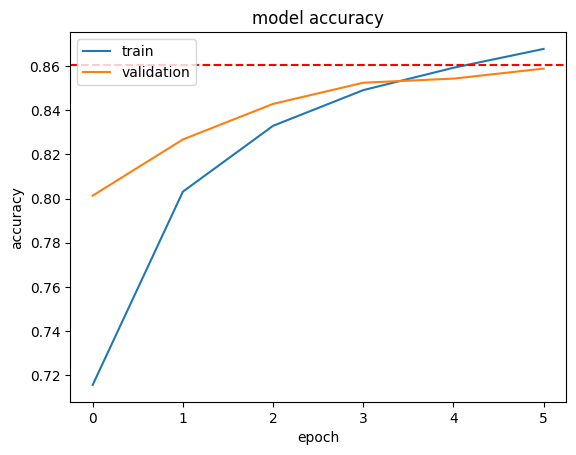

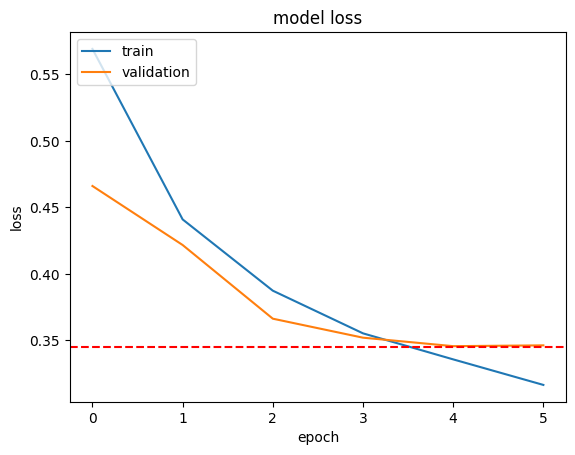

In [249]:
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.axhline(y=score[1], color='r', linestyle='--', label='Test Accuracy')

plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc = 'upper left')
plt.show()

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.axhline(y=score[0], color='r', linestyle='--', label='Test Loss')

plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train','validation'], loc = 'upper left')
plt.show()

235/235 ━━━━━━━━━━━━━━━━━━━━ 12s 49ms/step


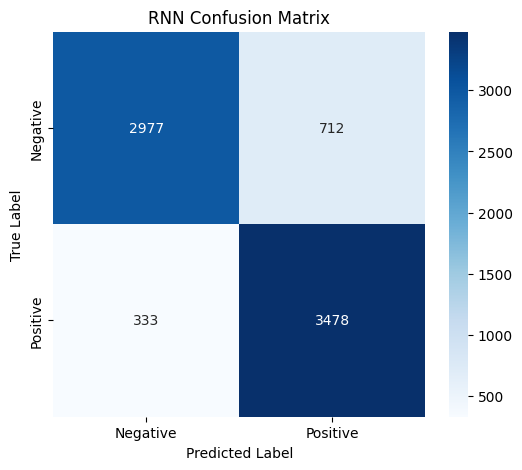

In [250]:
y_pred_probs = model.predict(X_test_nn)

y_pred = (y_pred_probs > 0.5).astype(int)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.title('RNN Confusion Matrix')
plt.show()

In [251]:
report_dict = classification_report(y_test, y_pred, output_dict=True)
df_report = pd.DataFrame(report_dict).transpose()
df_report

,precision,recall,f1-score,support
0,0.899396,0.806994,0.850693,3689.000000
1,0.830072,0.912621,0.869391,3811.000000
accuracy,0.860667,0.860667,0.860667,0.860667
macro avg,0.864734,0.859808,0.860042,7500.000000
weighted avg,0.864170,0.860667,0.860194,7500.000000
